In [29]:

import os
import matplotlib.pyplot as plt
import glob
import torch

def find_saved_latent(path = f"logs/VAE/train/", cfg_name='config'):
    """
    Find saved latent vectors from VAE training
    """

    VAE_data = {}
    for version in os.listdir(path):
        version_num = version.split('_')[-1]
        contents = os.listdir(f"{path}{version}")
        base_path = os.path.join(path, version, )

        if 'saved_latent' in contents:
            print(f"Found saved latent vectors for version {version_num}")
            cfg_file = None  # get config file
            for file in contents:
                if cfg_name in file and file.endswith('.yaml'):
                    cfg_file = file
                    break
            
            projection = None  # get projection image
            for file in contents:
                if 'projection' in file and file.endswith('.png'):
                    projection = file
                    break

            checkpoints = glob.glob(f"{base_path}/checkpoints/*")  # check for checkpoints
            saved_latent = os.listdir(os.path.join(base_path, 'saved_latent'))  # open saved_latent and check whats inside

            VAE_data[version_num] = {
                'saved_latent' : saved_latent,
                'paths' : {
                    'config' : os.path.join(base_path, cfg_file),
                    'saved_latent' : os.path.join(base_path, 'saved_latent'),
                    'projection' : os.path.join(base_path, projection),
                    'checkpoints' : checkpoints,
                    'log' : base_path,
                },
                'contents' : contents
            }

    return VAE_data

def show_saved_latent_info(data, return_fig=False):

    saved_latent_info = {}

    for version, info in data.items():
        saved_latent = info['saved_latent']
        saved_latent_info[version] = {
            'num_files' : len(saved_latent),
            'size' : None,
            'min' : None,
            'max' : None,
            'std_dev' : None,
            'projection' : None
        }

        for file in saved_latent:
            # get size of file
            # get min and max values
            # get std dev
            pass

        # projection_image = plt.imread(info['paths']['projection'])
        saved_latent_info[version]['projection'] = info['paths']['projection']

    fig, ax = plt.subplots(2, len(data), figsize=(20, 10))
    if len(data) == 1:
        ax = ax.reshape(2, 1)
    for i, (version, info) in enumerate(data.items()):
        ax[0, i].imshow(plt.imread(info['paths']['projection']))
        ax[0, i].set_title(f"Version {version}")
        ax[0, i].axis('off')

        ax[1, i].text(0.5, 0.5, f"Num Files: {saved_latent_info[version]['num_files']}", ha='center', va='center')
        ax[1, i].axis('off')
    if return_fig:
        return fig

    plt.show()

def latent_picker(path, cfg_name='config', show=True):
    data = find_saved_latent(path, cfg_name)
    # print(data)

    # if the user has difficulty picking a version, show info
    ## info to show: projection image, config file, saved_latent vectors (how many?, how big?, min/max values?, std dev?, etc.)
    ## also show the checkpoint files
    if len(data) == 0:
        print("No saved latent vectors found.")
        return None, None
    elif len(data) == 1:
        print("Only one version found.")
        version = list(data.keys())[0]
        return data[version], version
    
    else:
        if show:
            show_saved_latent_info(data)

        # ask user for input of version number
        print("Please enter the version number you would like to use: ")
        for version in data.keys():
            print(f"\t{version}")
        version = input('Version: ')

        return data[version], version

def load_latent(data_version, y_name='/y.pt'):
    path = data_version['paths']['saved_latent']
    z = torch.load(path + '/z.pt').to(torch.device('mps'))
    y = torch.load(path + y_name).to(torch.device('mps'))
    autoencoder = torch.load(path + '/model.pth').to(torch.device('mps'))
    projector = torch.load(path + '/projector.pt')
    projection = torch.load(path + '/projection.pt')

    # load checkpoint
    # checkpoint = torch.load(data_version['paths']['checkpoints'][0])
    # autoencoder.load_state_dict(checkpoint['autoencoder_state_dict'])

    return z, y , autoencoder, projector, projection


VAE_version = 'VAE5'
data_version, version = latent_picker(f'logs/{VAE_version}/train/', cfg_name='hparams')
z, texts , autoencoder, projector, projection = load_latent(data_version, y_name='/texts.pt')

Found saved latent vectors for version 13
Only one version found.


In [30]:
z.shape, texts.shape

(torch.Size([96, 256]), torch.Size([96, 3, 250]))

In [31]:
import numpy as np
idx2word = np.load('../stranger_repos/HumanML3D/HumanML3D/texts_enc/simple/idx2word.npz', allow_pickle=True)['arr_0'].item()
word2idx = np.load('../stranger_repos/HumanML3D/HumanML3D/texts_enc/simple/word2idx.npz', allow_pickle=True)['arr_0'].item()

def translate(txt, idx2word):
    return ' '.join([idx2word[i.item()] for i in txt])

def translate_inv(txt, word2idx, max_len=250):
    enc =  [word2idx[i] for i in txt.split()]
    return torch.tensor(enc + [0] * (max_len - len(enc)))

print('Does the encoder work as expected: ',(texts[0][0].detach().cpu() == translate_inv(translate(texts[0][0], idx2word), word2idx)).all())
print(translate(texts[0][0], idx2word))


Does the encoder work as expected:  tensor(True)
a person jogs in a straight line.                                                                                                                                                                                                                                                   


In [33]:
if VAE_version == 'VAE5':
    reconstruction = autoencoder.model.decode(z[0].unsqueeze(0), 
                                              torch.tensor([200]).to(torch.device('mps')))

elif VAE_version == 'VAE1':
    # if VAE1
    reconstruction = autoencoder.decode(z[0].unsqueeze(0))
reconstruction.shape

torch.Size([1, 420, 66])

In [34]:
from utils import plot_3d_motion_animation

plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), translate(texts[0][0], idx2word), 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon.mp4", velocity=False)
plt.close()

(420, 22, 3)
(200, 22, 3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Projection shape: (96, 2)


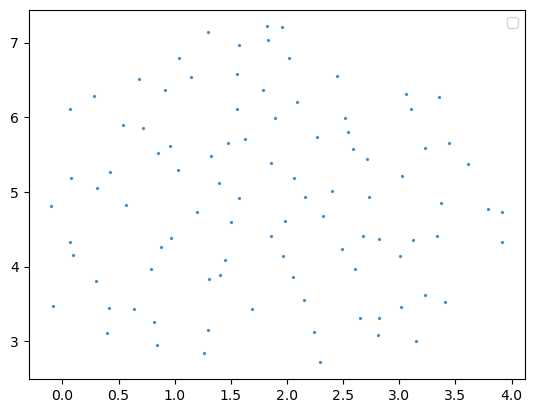

In [35]:
print('Projection shape:', projection.shape)
plt.scatter(projection[:, 0], 
            projection[:, 1], 
            # c=range(len(projection)), cmap="tab10", 
            alpha=0.7, s=2)


# points = torch.tensor([
#     [9.3, .8],
#     [4.7,-3.2],
#     [4, -1.3],
#     [-2.1, -1.2]

# ]).float()
# for i, point in enumerate(points):
#     plt.scatter(point[0], point[1], label=f"point {i}", s=100, marker='x', linewidths=8)

plt.legend()


# Diffusion model!

*we should pass the text throguh a large language model first to get words like stroll and walk to be similar. () roberta-base*

In [36]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset


class LatentSpaceDataModule(pl.LightningDataModule):
    def __init__(self, z, texts, batch_size=32):
        super().__init__()
        # print('z shape:', z.shape)  # this is (n, z_dim)
        # print('texts shape:', texts.shape) # this is (n, 3, text_len) -> 3 is for the 3 different texts
        self.z = z.repeat(3, 1)  # repeat z for each text
        self.texts = texts.view(-1, texts.shape[-1])  # flatten texts
        # print('z shape:', self.z.shape)  # this is (n*3, z_dim)
        # print('texts shape:', self.texts.shape) # this is (n*3, text_len)
        self.batch_size = batch_size
        self.latent_dim = z.shape[-1]

    def setup(self, stage=None):
        
        # split data into train, val, test
        dataset = TensorDataset(self.z, self.texts)

        # train/val/test split
        n = len(dataset)
        n_train = int(0.8 * n)
        n_val = int(0.1 * n)
        n_test = n - n_train - n_val

        train_data, val_data, test_data = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)
    



In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math
from tqdm import tqdm
import torchvision

class SimpleModel(nn.Module):
    # a simple model takes (batchsize, latent dim),
    # performs linear layers
    # and returns (batchsize, latent dim)

    def __init__(
        self,
        latent_dim,
        hidden_dim,
        nhidden=5,
        timesteps=1000,
        time_embedding_dim=64,
        target_embedding_dim=5,
        target_size=10054,
        dp_rate=0.1,
        verbose=False
    ):
        super(SimpleModel, self).__init__()
        self.verbose = verbose
        self.time_embedding_dim = time_embedding_dim
        self.target_embedding_dim = target_embedding_dim
        self.time_embedding = nn.Embedding(timesteps, time_embedding_dim)
        self.target_embedding = nn.Embedding(target_size+1, target_embedding_dim, sparse=False)
        # dropout
        self.dropout = nn.Dropout(dp_rate)

        input_dim = latent_dim + time_embedding_dim + 250*4
        out_put_dim = latent_dim
        self.fc1 = nn.Linear(
            input_dim, hidden_dim
        )
        
        # input_dim = 11036
        self.fc_hidden = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(nhidden)]
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim),
        )

        # text transformer encoder
        self.text_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=target_embedding_dim,
                nhead=10,
                dim_feedforward=512,
                dropout=0.1,
                activation='relu',
                batch_first=True
            ),
            num_layers=3
        )
        self.text_linear1 = nn.Linear(target_embedding_dim, 4)

    def forward(self, x, y, t):
        if self.verbose:
            print('x', x.shape)
            print('y', y.shape)
            print('t', t.shape)

        t = self.time_embedding(t)  # (batchsize, time_embedding_dim)
        if self.verbose:
            print('t', t.shape)
        y = self.target_embedding(y)
        if self.verbose:
            print('y (after target embedding)', y.shape)

        y = self.text_transformer(y)
        if self.verbose:
            print('y', y.shape)
        y = self.text_linear1(y)
        y = nn.Flatten()(y)
        if self.verbose:
            print('y (done)', y.shape)
            print('t', t.shape)
            print('x', x.shape)
        

        x = torch.cat([x, t, y], dim=1)
        if self.verbose:
            print('after cat: x', x.shape)
        x = self.fc1(x)
        if self.verbose:
            print('x', x.shape)
        for layer in self.fc_hidden:
            # x = torch.relu(layer(x))
            x = nn.LeakyReLU()(layer(x))
            x = self.dropout(x)

        x = self.fc2(x)
        return x

class LatentDiffusion(nn.Module):
    def __init__(
        self,
        latent_dim=8,
        hidden_dim=64,
        nhidden=3,
        timesteps=1000,
        time_embedding_dim=64,
        target_embedding_dim=5,
        epsilon=0.008,
        dp_rate=0.1,
        verbose=False
    ):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = latent_dim

        betas = self._cosine_variance_schedule(timesteps, epsilon)
        # print('betas', betas.shape)

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        # print('alphas_cumprod', alphas_cumprod.shape)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.model = SimpleModel(
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            nhidden=nhidden,
            timesteps=timesteps,
            time_embedding_dim=time_embedding_dim,
            target_embedding_dim=target_embedding_dim,
            dp_rate=dp_rate,
            verbose=verbose
        )

    def forward(self, x, y, noise):
        # x:NCHW
        t = torch.randint(0, self.timesteps, (x.shape[0],)).to(x.device)
        # print('t from the LatentDIffusion forward', t)

        x_t = self._forward_diffusion(x, t, noise)

        # print('x_t', x_t.shape, )
        # print('t', t.shape)
        pred_noise = self.model(x_t, y, t)
        # print('pred_noise', pred_noise.shape)

        return pred_noise

    @torch.no_grad()
    def sampling(self, n_samples, clipped_reverse_diffusion=True, device="cuda"):
        x_t = torch.randn(
            (n_samples, self.in_channels, self.image_size, self.image_size)
        ).to(device)
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            noise = torch.randn_like(x_t).to(device)
            t = torch.tensor([i for _ in range(n_samples)]).to(device)

            if clipped_reverse_diffusion:
                x_t = self._reverse_diffusion_with_clip(x_t, t, noise)
            else:
                x_t = self._reverse_diffusion(x_t, t, noise)

        x_t = (x_t + 1.0) / 2.0  # [-1,1] to [0,1]

        return x_t

    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)

        return betas

    def _forward_diffusion(self, x_0, t, noise):
        # print('x_0', x_0.shape)
        # print('noise', noise.shape)
        # print('t', t)

        assert x_0.shape == noise.shape
        # print('self.sqrt_alphas_cumprod.gather(t)', self.sqrt_alphas_cumprod.gather(0,t).shape)
        # q(x_{t}|x_{t-1})

        A = self.sqrt_alphas_cumprod.gather(0, t).unsqueeze(1)
        B = self.sqrt_one_minus_alphas_cumprod.gather(0, t).unsqueeze(1)
        # print('A', A.shape)
        # print('B', B.shape)
        # print('noise', noise.shape)
        # print('x_0', x_0.shape)
        return A * x_0 + B * noise

    @torch.no_grad()
    def _reverse_diffusion(self, x_t, y, t, noise):
        """
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        """
        pred = self.model(x_t, y, t)

        alpha_t = self.alphas.gather(-1, t).reshape(x_t.shape[0], 1)  # ,1,1)
        # print('alpha_t', alpha_t.shape)
        alpha_t_cumprod = self.alphas_cumprod.gather(-1, t).reshape(
            x_t.shape[0], 1
        )  # ,1,1)
        beta_t = self.betas.gather(-1, t).reshape(x_t.shape[0], 1)  # ,1,1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod.gather(
            -1, t
        ).reshape(
            x_t.shape[0], 1
        )  # ,1,1)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_alpha_cumprod_t) * pred
        )

        if t.min() > 0:
            alpha_t_cumprod_prev = self.alphas_cumprod.gather(-1, t - 1).reshape(
                x_t.shape[0], 1
            )  # ,1,1)
            std = torch.sqrt(
                beta_t * (1.0 - alpha_t_cumprod_prev) / (1.0 - alpha_t_cumprod)
            )
        else:
            std = 0.0

        return mean + std * noise

# make pl model
class LatentDiffusionModel(pl.LightningModule):
    def __init__(
        self,
        autoencoder,
        verbose = False,
        **kwargs,
    ):
        super().__init__()
        self.verbose = verbose
        self.lr = kwargs.get("lr", 0.001)
        self.model = LatentDiffusion(
            latent_dim=kwargs.get("latent_dim", 8),
            hidden_dim=kwargs.get("hidden_dim", 64),
            nhidden=kwargs.get("nhidden", 5),
            timesteps=kwargs.get("timesteps", 100),
            time_embedding_dim=kwargs.get("time_embedding_dim", 8),
            epsilon=kwargs.get("epsilon", 0.008),
            target_embedding_dim=kwargs.get("target_embedding_dim", 8),
            dp_rate=kwargs.get("dp_rate", 0.1),
            verbose=verbose
        )
        self.noise_multiplier = kwargs.get("noise_multiplier", .1)
        # self.save_hyperparameters()
        self.autoencoder = autoencoder
        self.autoencoder.eval()

    def forward(self, data):
        x, y = data
        if self.verbose:
            print('x', x.shape)
            print('y', y.shape)
        noise = torch.randn_like(x) * self.noise_multiplier
        return self.model(x, y, noise), noise
    
    def _reverse_diffusion(self, x_t, y, t):
        noise = torch.randn_like(x_t)
        return self.model._reverse_diffusion(x_t, y, t, noise)

    def training_step(self, batch, batch_idx):
        pred_noise, noise = self.forward(batch)
        # print('pred_noise', pred_noise.shape)
        loss = nn.functional.mse_loss(pred_noise, noise)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        pred_noise, noise = self.forward(batch)
        loss = nn.functional.mse_loss(pred_noise, noise)


        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        if batch_idx == 0 and self.autoencoder is not None:
            with torch.no_grad():
                # make image by decoding latent space
                x, y = batch
                # print(x.shape, y.shape)
                pred_clean = x-pred_noise
                x_dirty = x + noise

                raw_reconstruction = self.autoencoder.decode(x_dirty)
                reconstruction = self.autoencoder.decode(pred_clean)
                # print('reconstruction', reconstruction.shape)

                # raw_and_recon = torch.cat([raw_reconstruction[:8], reconstruction[:8], ])

                # grid = torchvision.utils.make_grid(raw_and_recon[:16], nrow=8, normalize=True)
                # self.logger.experiment.add_image('top: noisy input, bot: reconstruction', grid, global_step=self.global_step)

                plot_3d_motion_animation(raw_reconstruction[0].cpu().detach().numpy(), translate(y[0], idx2word), 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon_dirty.mp4", velocity=False)
                plt.close()

                plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), translate(y[0], idx2word), 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon_clean.mp4", velocity=False)
                plt.close()

        return loss

    def test_step(self, batch, batch_idx):
        pred_noise, noise = self.forward(batch)
        loss = nn.functional.mse_loss(pred_noise, noise) / self.noise_multiplier
        self.log(
            "test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


data_module = LatentSpaceDataModule(z, texts, batch_size=4)
data_module.setup()

model = LatentDiffusionModel(
    latent_dim=data_module.latent_dim,
    hidden_dim=512,
    nhidden=5,
    timesteps=1000,
    time_embedding_dim=12,
    target_embedding_dim=100,
    epsilon=0.0008,
    dp_rate=0.1,
    autoencoder=autoencoder.model if VAE_version == 'VAE5' else autoencoder,
    lr = 0.0001,
    verbose=False
)


# train
trainer = pl.Trainer(max_epochs=100, accelerator='mps')
trainer.fit(model, data_module)

# batch = next(iter(dm.train_dataloader()))

# model(batch)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                            | Params
----------------------------------------------------------------
0 | model       | LatentDiffusion                 | 3.5 M 
1 | autoencoder | CascadingTransformerAutoEncoder | 17.5 M
----------------------------------------------------------------
21.1 M    Trainable params
0         Non-trainable params
21.1 M    Total params
84.222    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


TypeError: decode() missing 1 required positional argument: 'lengths'

## Predict

In [76]:
# predict text input
text_input = 'jumping jacks'

text_enc_input = translate_inv(text_input, word2idx).unsqueeze(0)
noisy_latent = (torch.randn_like(z[0]) * 8.0).unsqueeze(0)
print('text_enc_input', text_enc_input.shape)
print('noisy_latent', noisy_latent.shape)
# pred_noise, noise = model((noisy_latent.unsqueeze(0), text_enc_input.unsqueeze(0)))
print(noisy_latent.sum())
# # subtact pred
t = 9
out = noisy_latent.clone().to(torch.device('mps'))
for i in range(t, 1, -1):
    print(i, end='\r')
    out = model._reverse_diffusion(out.to(torch.device('mps')),
                                   text_enc_input.to(torch.device('mps')),
                                   torch.tensor([i]).to(torch.device('mps')) )
    # print(noisy_latent.shape)

print(noisy_latent.sum())
print(out.sum())
# decode
reconstruction = autoencoder.decode(out)
recon_noisy = autoencoder.decode(noisy_latent.to(torch.device('mps')))
print(reconstruction.shape)

plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), text_input,
                                        figsize=(10, 10), fps=20, radius=2, save_path=f"recon_text.mp4", velocity=False)
plt.close()

plot_3d_motion_animation(recon_noisy[0].cpu().detach().numpy(), text_input,
                                        figsize=(10, 10), fps=20, radius=2, save_path=f"recon_text_noisy.mp4", velocity=False)
plt.close()



text_enc_input torch.Size([1, 250])
noisy_latent torch.Size([1, 256])
tensor(-174.4735, device='mps:0')
tensor(-174.4735, device='mps:0')
tensor(-174.3026, device='mps:0')


/var/folders/s5/y8d9ljs52g7bqbgnrq59ltv40000gn/T/ipykernel_44151/12557977.py:229: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  if t.min() > 0:


torch.Size([1, 420, 22, 3])
(420, 22, 3)
(420, 22, 3)
(420, 22, 3)
(420, 22, 3)


In [123]:
torch.tensor([i]).to(noisy_latent.device).device

device(type='cpu')